In [0]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set()

# 1
## 1.1

In [0]:
import numpy as np

def sample_data_1():
    count = 100000
    rand = np.random.RandomState(0)
    return [[1.0, 2.0]] + rand.randn(count, 2) * [[5.0, 1.0]]


def sample_data_2():
    count = 100000
    rand = np.random.RandomState(0)
    return [[1.0, 2.0]] + (rand.randn(count, 2) * [[5.0, 1.0]]).dot(
            [[np.sqrt(2) / 2, np.sqrt(2) / 2], [-np.sqrt(2) / 2, np.sqrt(2) / 2]])

In [0]:
data_1 = sample_data_1()
data_2 = sample_data_2()

In [0]:
from torch import nn

class VAE(nn.Module):
    
    def __init__(self, in_dim=2, latent_dim=2, device='cpu'):
        super().__init__()
        self.device = device
        self.decoder = nn.Sequential(nn.Linear(latent_dim, 128),
                                     nn.ELU(),
                                     nn.Linear(128, 64),
                                     nn.ReLU(),
                                     nn.Linear(64, 4))
        self.encoder = nn.Sequential(nn.Linear(in_dim, 128),
                                     nn.ELU(),
                                     nn.Linear(128, 64),
                                     nn.ReLU(),
                                     nn.Linear(64, 4))
    
    
    def forward(self, x):
        mu, log_var = self.encoder(x).split(2, dim=1)
        std = torch.exp(0.5 * log_var)
        e = torch.randn_like(log_var).to(self.device)
        z = mu + e * std
        mu_x, var_x = self.decoder(z).split(2, dim=1)
        var_x = torch.exp(var_x)
        return mu_x, var_x, mu, std ** 2

In [0]:
from torch import optim

def train(model, data_loader, epochs=10, lr=2e-4):

    opt = optim.Adam(model.parameters(), lr=lr)

    train_log_kl = []
    train_log_dec = []
    train_log_elbo = []

    for i in range(epochs):
        for j, batch in enumerate(data_loader):
            mu_x, var_x, mu_z, var_z = model(batch.cuda().float())
            posterior = torch.distributions.MultivariateNormal(mu_x, torch.diag_embed(var_x)) 
            prior = torch.distributions.MultivariateNormal(torch.zeros(2).cuda(), torch.eye(2).cuda()) 
            q = torch.distributions.MultivariateNormal(mu_z, torch.diag_embed(var_z ** 2)) 
            
            nll = -posterior.log_prob(batch.cuda().float())
            kl = torch.distributions.kl_divergence(q, prior)

            loss = torch.mean(nll + kl)
            
            loss.backward()
            opt.step()
            opt.zero_grad()

            train_log_dec.append(torch.mean(nll).detach().cpu().item() / 2.0)
            train_log_kl.append(torch.mean(kl).detach().cpu().item())
            train_log_elbo.append((-loss).detach().cpu().item())
    return train_log_elbo, train_log_kl, train_log_dec

In [0]:
import torch

model = VAE()
data_1_loader = torch.utils.data.DataLoader(data_1, batch_size=164, shuffle=True)
train_log_elbo, train_log_kl, train_log_dec = train(model, data_1_loader)

In [0]:
def sample(decoder, samples=100000):
    z = torch.randn([samples, 2])
    mu, log_var = decoder(z.cuda()).split(2, dim=1)
    std = torch.exp(0.5 * log_var)
    e = torch.randn_like(log_var)
    z = mu + e * std
    return z, mu


def plot_samples(z, mu):
    noisy_x = noisy_x.cpu().data.numpy()
    mu = mu.cpu().detach().numpy()
    plt.scatter(z[:, 0], z[:, 1], marker='.', label="Full path samples")
    plt.scatter(mu[:, 0], mu[:, 1], marker='.', label="Mean")
    plt.legend()

In [0]:
def plot(y, title):
    x = np.arange(len(y))
    plt.plot(x, y)
    plt.title(title)
    plt.show()

### Dataset 1, Diagonal variance

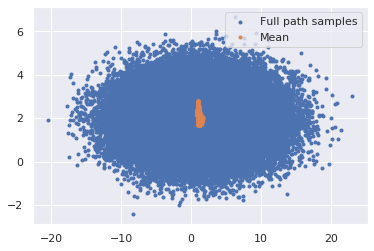

In [0]:
plot_samples(*sample(model.decoder))

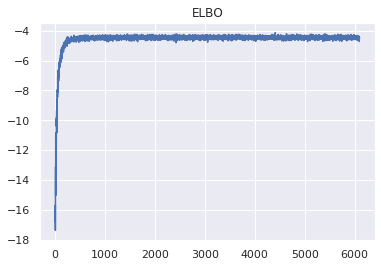

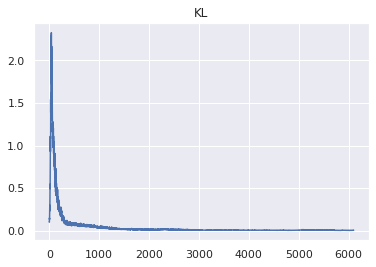

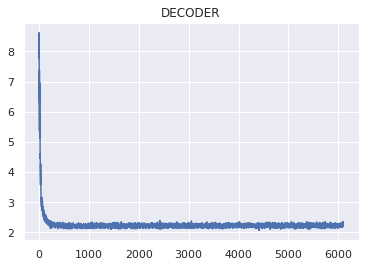

In [0]:
plot(train_log_elbo, 'ELBO')
plot(train_log_kl, 'KL')
plot(train_log_dec, 'DECODER')

### Dataset 2, Diagonal variance

In [0]:
model = VAE()
data_2_loader = torch.utils.data.DataLoader(data_2, batch_size=164, shuffle=True)
train_log_elbo, train_log_kl, train_log_dec = train(model, data_2_loader)

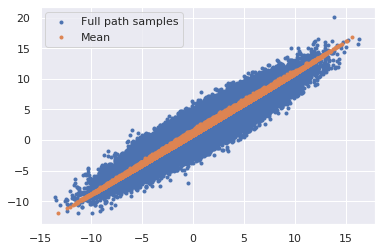

In [0]:
plot_samples(*sample(model.decoder))

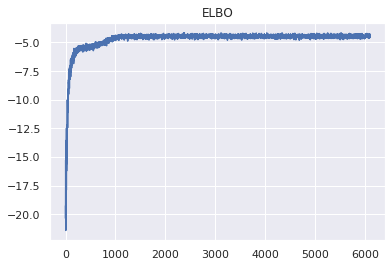

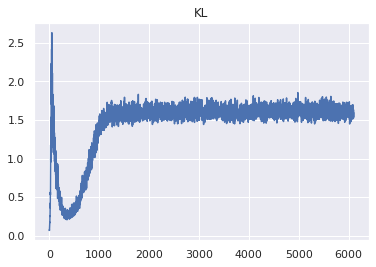

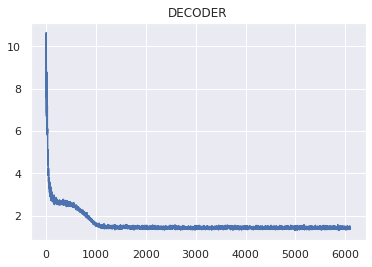

In [0]:
plot(train_log_elbo, 'ELBO')
plot(train_log_kl, 'KL')
plot(train_log_dec, 'DECODER')

In [0]:
class VAESingle(nn.Module):
    
    def __init__(self, in_dim=2, latent_dim=2, device='cpu'):
        super().__init__()
        self.device = device
        self.decoder = nn.Sequential(nn.Linear(latent_dim, 128),
                                     nn.ReLU(),
                                     nn.Linear(128, 64),
                                     nn.ReLU(),
                                     nn.Linear(64, 3))
        self.encoder = nn.Sequential(nn.Linear(in_dim, 128),
                                     nn.ReLU(),
                                     nn.Linear(128, 64),
                                     nn.ReLU(),
                                     nn.Linear(64, 4))
    
    
    def forward(self, x):
        mu, log_var = self.encoder(x).split(2, dim=1)
        std = torch.exp(0.5 * log_var)
        e = torch.randn_like(log_var).to(self.device)
        z = mu + e * std
        mu_x, var_x = self.decoder(z).split(2, dim=1)
        var_x = torch.exp(var_x)
        return mu_x, var_x, mu, std

In [0]:
from torch import optim

def train(model, data_loader, epochs=10, lr=1e-3, batch_size=125):

    opt = optim.Adam(model.parameters(), lr=lr)

    train_log_kl = []
    train_log_dec = []
    train_log_elbo = []

    for i in range(epochs):
        for j, batch in enumerate(data_loader):
            mu_x, var_x, mu_z, var_z = model(batch.float())
            posterior = torch.distributions.MultivariateNormal(mu_x, var_x.unsqueeze(-1) * torch.eye(2).reshape(1, 2, 2).repeat(var_x.shape[0], 1, 1)) 
            prior = torch.distributions.MultivariateNormal(torch.zeros(2), torch.eye(2)) 
            q = torch.distributions.MultivariateNormal(mu_z, torch.diag_embed(var_z ** 2)) 
            
            nll = -posterior.log_prob(batch.float())
            kl = torch.distributions.kl_divergence(q, prior)

            loss = torch.mean(nll + kl)
            
            loss.backward()
            opt.step()
            opt.zero_grad()

            train_log_dec.append(torch.mean(nll).detach().item() / 2.0)
            train_log_kl.append(torch.mean(kl).detach().item())
            train_log_elbo.append((-loss).detach().item())
    return train_log_elbo, train_log_kl, train_log_dec

### Dataset 1, Single variance

In [0]:
model = VAESingle()
data_1_loader = torch.utils.data.DataLoader(data_1, batch_size=164, shuffle=True)
train_log_elbo, train_log_kl, train_log_dec = train(model, data_1_loader)

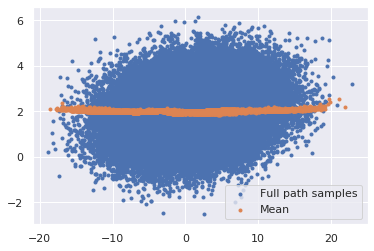

In [0]:
plot_samples(*sample(model.decoder))

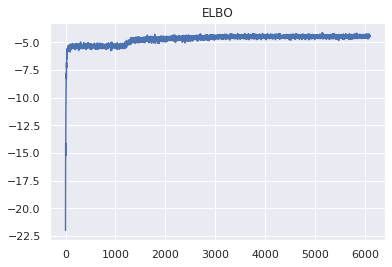

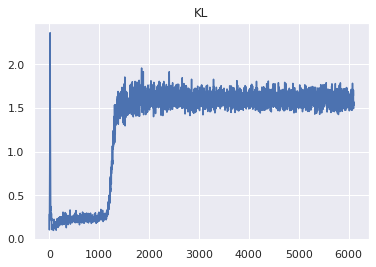

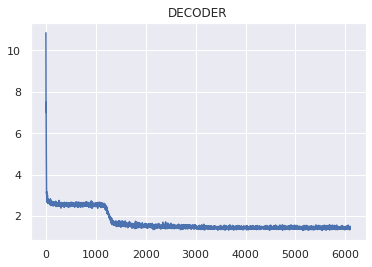

In [0]:
plot(train_log_elbo, 'ELBO')
plot(train_log_kl, 'KL')
plot(train_log_dec, 'DECODER')

### Dataset 2, Single variance

In [0]:
model = VAESingle()
data_2_loader = torch.utils.data.DataLoader(data_2, batch_size=164, shuffle=True)
train_log_elbo, train_log_kl, train_log_dec = train(model, data_2_loader)

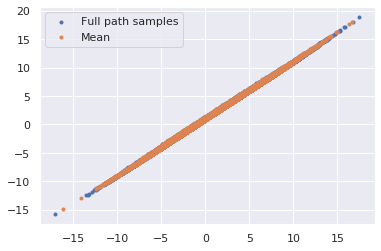

In [0]:
plot_samples(*sample(model.decoder))

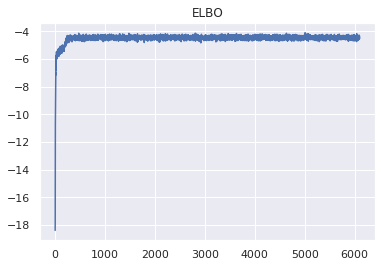

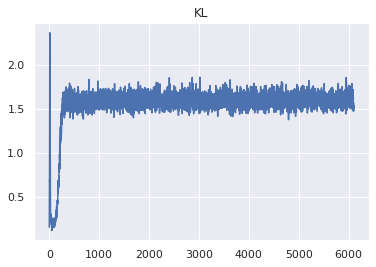

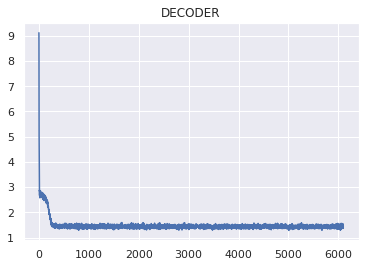

In [0]:
plot(train_log_elbo, 'ELBO')
plot(train_log_kl, 'KL')
plot(train_log_dec, 'DECODER')

## 1.2

In [0]:
import numpy as np

def sample_data_3():
    count = 100000
    rand = np.random.RandomState(0)
    a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
        -np.sin(np.linspace(0, np.pi, count // 3))]

    c += rand.randn(*c.shape) * 0.2
    data_x = np.concatenate([a, b, c], axis=0)
    data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
    perm = rand.permutation(len(data_x))
    return data_x[perm], data_y[perm]

def sample_test_3():
    count = 20000
    rand = np.random.RandomState(0)
    a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
        -np.sin(np.linspace(0, np.pi, count // 3))]

    c += rand.randn(*c.shape) * 0.2
    data_x = np.concatenate([a, b, c], axis=0)
    data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
    perm = rand.permutation(len(data_x))
    return data_x[perm], data_y[perm]

def sample_val_3():
    count = 2000
    rand = np.random.RandomState(0)
    a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
        -np.sin(np.linspace(0, np.pi, count // 3))]

    c += rand.randn(*c.shape) * 0.2
    data_x = np.concatenate([a, b, c], axis=0)
    perm = rand.permutation(len(data_x))
    return data_x[perm]

In [0]:
data_3, labels_3 = sample_data_3()
val_3 = sample_val_3() 

In [0]:
from torch import optim

def train(model, data_loader, val_loader, epochs=10, lr=1e-3):

    opt = optim.Adam(model.parameters(), lr=lr)

    train_log_kl = []
    train_log_dec = []
    train_log_elbo = []

    val_log_kl = []
    val_log_dec = []
    val_log_elbo = []
    prior = torch.distributions.MultivariateNormal(torch.zeros(2).cuda(), torch.eye(2).cuda()) 

    for i in range(epochs):
        for j, batch in enumerate(data_loader):
            mu_x, var_x, mu_z, var_z = model(batch.cuda().float())
            posterior = torch.distributions.MultivariateNormal(mu_x, torch.diag_embed(var_x)) 
            q = torch.distributions.MultivariateNormal(mu_z, torch.diag_embed(var_z)) 
            
            nll = -posterior.log_prob(batch.cuda().float())
            # kl = torch.distributions.kl.kl_divergence(q, prior)
            kl = 1.0 + torch.log(var_z) - mu_z ** 2 - var_z
            kl = -0.5 * kl.sum(dim=1, keepdim=True)
            # print(kl_1 - kl)

            loss = torch.mean(nll + kl)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            opt.zero_grad()
            train_log_dec.append(torch.mean(nll).detach().cpu().item() / 2.0)
            train_log_kl.append(torch.mean(kl).detach().cpu().item())
            train_log_elbo.append((-loss).detach().cpu().item())

            if (j + 1) % 10 == 0:
              with torch.no_grad():
                for val_batch in val_loader:
                  mu_x, var_x, mu_z, var_z = model(val_batch.cuda().float())
                  posterior = torch.distributions.MultivariateNormal(mu_x, torch.diag_embed(var_x)) 
                  q = torch.distributions.MultivariateNormal(mu_z, torch.diag_embed(var_z ** 2)) 
            
                  nll = -posterior.log_prob(val_batch.cuda().float())
                  kl = torch.distributions.kl_divergence(q, prior)

                  loss = torch.mean(nll + kl)
                  val_log_dec.append(torch.mean(nll).detach().cpu().item() / 2.0)
                  val_log_kl.append(torch.mean(kl).detach().cpu().item())
                  val_log_elbo.append((-loss).detach().cpu().item())

    return train_log_elbo, train_log_kl, train_log_dec, val_log_elbo, val_log_kl, val_log_dec

In [0]:
import torch

model = VAE(device='cuda').cuda()
data_3_loader = torch.utils.data.DataLoader(data_3, batch_size=1000, shuffle=True)
val_data_loader = torch.utils.data.DataLoader(val_3, batch_size=1000, shuffle=True)
train_log_elbo, train_log_kl, train_log_dec, val_log_elbo, val_log_kl, val_log_dec = train(model, data_3_loader, val_data_loader, 1000)

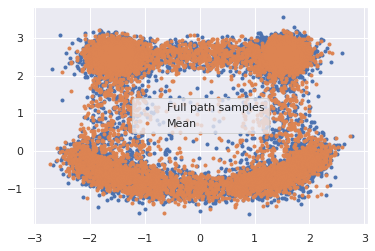

In [151]:
plot_samples(*sample(model.decoder, samples=10000))

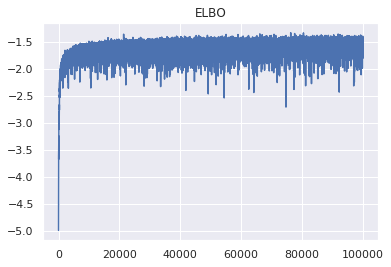

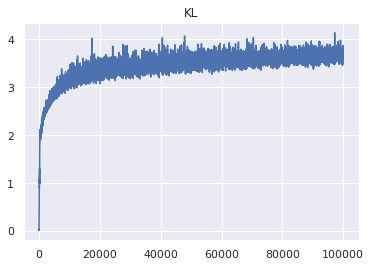

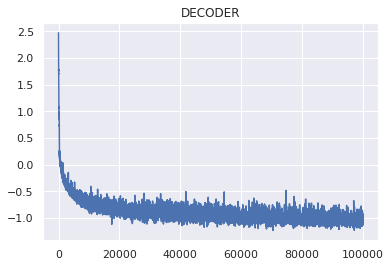

In [136]:
plot(train_log_elbo, 'ELBO')
plot(train_log_kl, 'KL')
plot(train_log_dec, 'DECODER')

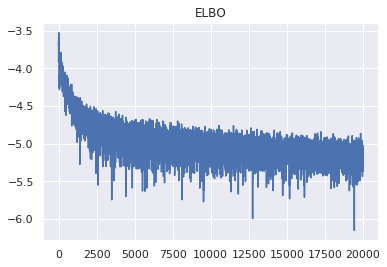

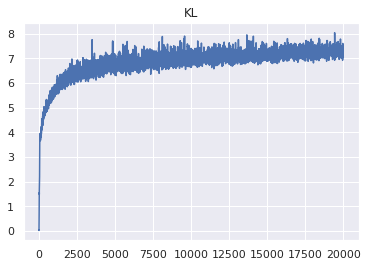

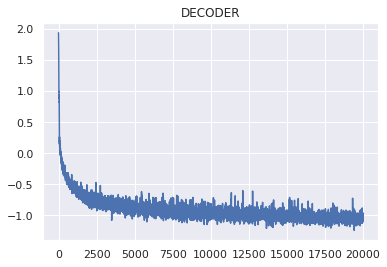

In [137]:
plot(val_log_elbo, 'ELBO')
plot(val_log_kl, 'KL')
plot(val_log_dec, 'DECODER')

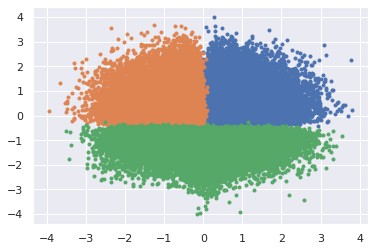

In [140]:
mu, log_var = model.encoder(torch.from_numpy(data_3).cuda().float()).split(2, dim=1)
std = torch.exp(0.5 * log_var)
e = torch.randn_like(log_var)
z = mu + e * std
z = z.detach().cpu().numpy()
plt.scatter(z[labels_3 == 0, 0], z[labels_3 == 0, 1], marker='.')
plt.scatter(z[labels_3 == 1, 0], z[labels_3 == 1, 1], marker='.')
plt.scatter(z[labels_3 == 2, 0], z[labels_3 == 2, 1], marker='.')

In [0]:
test_3, _ = sample_test_3()

In [147]:
data_3_loader = torch.utils.data.DataLoader(test_3, batch_size=1000, shuffle=True)
test_log_dec = 0
test_log_kl = 0
test_log_elbo = 0

for j, batch in enumerate(data_3_loader):
 mu_x, var_x, mu_z, var_z = model(batch.cuda().float())
 posterior = torch.distributions.MultivariateNormal(mu_x, torch.diag_embed(var_x)) 
 prior = torch.distributions.MultivariateNormal(torch.zeros(2).cuda(), torch.eye(2).cuda()) 
 q = torch.distributions.MultivariateNormal(mu_z, torch.diag_embed(var_z ** 2)) 
            
 nll = -posterior.log_prob(batch.cuda().float())
 kl = torch.distributions.kl_divergence(q, prior)

 loss = torch.mean(nll + kl)
            
 test_log_dec += torch.mean(nll).detach().cpu().item() / 2.0
 test_log_kl += torch.mean(kl).detach().cpu().item()
 test_log_elbo += torch.mean(loss).detach().cpu().item()

print(test_log_dec / 20)
print(test_log_kl / 20)
print(test_log_elbo / 20)

-1.00336052775383
7.334650874137878
5.327929759025574


In [0]:
def iwae(model, x, k=100):
    with torch.no_grad():
        mu, log_var = model.encoder(x).split(2, dim=1)
        std = torch.exp(0.5 * log_var)
        e = torch.randn((k, *log_var.shape)).cuda().float()
        z = mu + e * std
        mu_x, var_x = model.decoder(z.view(-1, 2)).split(2, dim=1)
        posterior = torch.distributions.MultivariateNormal(mu_x.view(z.shape), torch.diag_embed(torch.exp(var_x).view(z.shape)))
        prior = torch.distributions.MultivariateNormal(torch.zeros(2).cuda(), torch.eye(2).cuda()) 
        q = torch.distributions.MultivariateNormal(mu, torch.diag_embed(std ** 2))  

        post_prob = posterior.log_prob(x).exp()
        pri_prob = prior.log_prob(z).exp()
        q_prob = q.log_prob(z).exp()

        w = torch.mean((post_prob * pri_prob) / q_prob, dim=0)
        return torch.log(w).mean()

In [180]:
x = torch.from_numpy(test_3[:100]).cuda().float()
print(f'ELBO: {iwae(model, x, k=1)}')
print(f'IWAE: {iwae(model, x)}')

ELBO: -1.6316146850585938
IWAE: -1.4584662914276123
